<a href="https://colab.research.google.com/github/magdalenamorawska/Uczenie-Maszynowe-w-Finansach-/blob/Use-Case-2/Use_case_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

• Odpowiedz/ pokaz część danych z wylosowanego zadania

• Zbuduj system rekomendacyjny używając biblioteki SURPRISE

• Użyj dwóch algorytmów SVD oraz kNN w wersji wylosowanej

• Użyj optymalizacji parametrów metodą GRID search do wyboru
liczby sąsiadów z wylosowanego przedziału

• Użyj walidacji krzyżowej dla ostatecznego modelu

• Porównaj oba algorytmy pod względem czasu uczenia oraz
wylosowanych błędów\

Import bibliotek

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD
from surprise import accuracy



In [2]:
pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163001 sha256=98f358cbd088a923669df461a0173089d74076acfd5044e40512b6eb09ba91fa
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


Impoprt danych

In [4]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


1. Przegląd danych


Podaj liczbę filmów dla dzieci


In [9]:
dla_dzieci = movies['genres'].str.contains('Children', case=False).sum()

print("Liczba filmów dla dzieci:", dla_dzieci)


Liczba filmów dla dzieci: 664


Pokaż rozkład ocen filmów z 1995

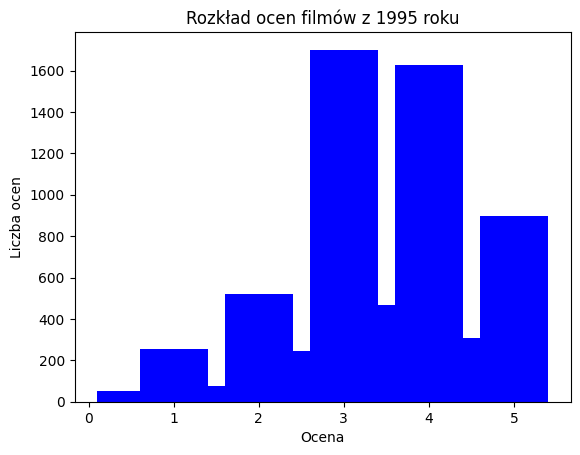

In [10]:
merged_data = pd.merge(ratings, movies, on='movieId', how='inner')

movies_1995 = merged_data[merged_data['title'].str.contains(r'\(1995\)', regex=True)]

rating_distribution_1995 = movies_1995['rating'].value_counts().sort_index()

plt.bar(rating_distribution_1995.index, rating_distribution_1995.values, color='blue')
plt.title('Rozkład ocen filmów z 1995 roku')
plt.xlabel('Ocena')
plt.ylabel('Liczba ocen')
plt.show()

Podaj średnią ocen wszystkich filmów akcji oraz 3 filmy najwyżej oceniane

In [16]:
filmy_akcji = movies[movies['genres'].str.contains("Action")]

srednia_ocena = ratings[ratings['movieId'].isin(filmy_akcji['movieId'])]["rating"].mean()

srednia_ocena_str = f"{srednia_ocena:.1f}"

print(f"Średnia ocena wszystkich filmów akcji: {srednia_ocena_str}")

Średnia ocena wszystkich filmów akcji: 3.4


In [19]:
top_3 = ratings[ratings['movieId'].isin(filmy_akcji['movieId'])].sort_values(by='rating', ascending=False).head(3)

top_3 = top_3.merge(filmy_akcji[['movieId', 'title']], how='inner', on='movieId')

print(f"3 najwyżej oceniane filmy akcji:")
for i, row in top_3.iterrows():
    print(f"{i+1}. {row['title']} (rating: {row['rating']:.1f})")

3 najwyżej oceniane filmy akcji:
1. Thing, The (1982) (rating: 5.0)
2. Star Wars: Episode VI - Return of the Jedi (1983) (rating: 5.0)
3. Star Wars: Episode VI - Return of the Jedi (1983) (rating: 5.0)


2. System rekomendacyjny



Przegląd i przygotowanie danych

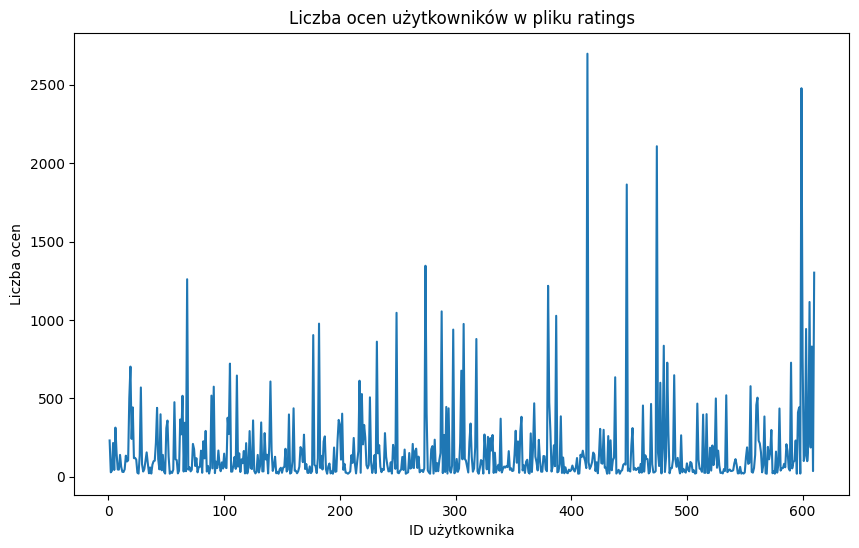

In [27]:
ilosc_ocen_uzytkownika = ratings.groupby('userId')['rating'].count()

plt.figure(figsize=(10, 6))
plt.plot(ilosc_ocen_uzytkownika.index, ilosc_ocen_uzytkownika.values)
plt.xlabel('ID użytkownika')
plt.ylabel('Liczba ocen')
plt.title('Liczba ocen użytkowników w pliku ratings')
plt.show()

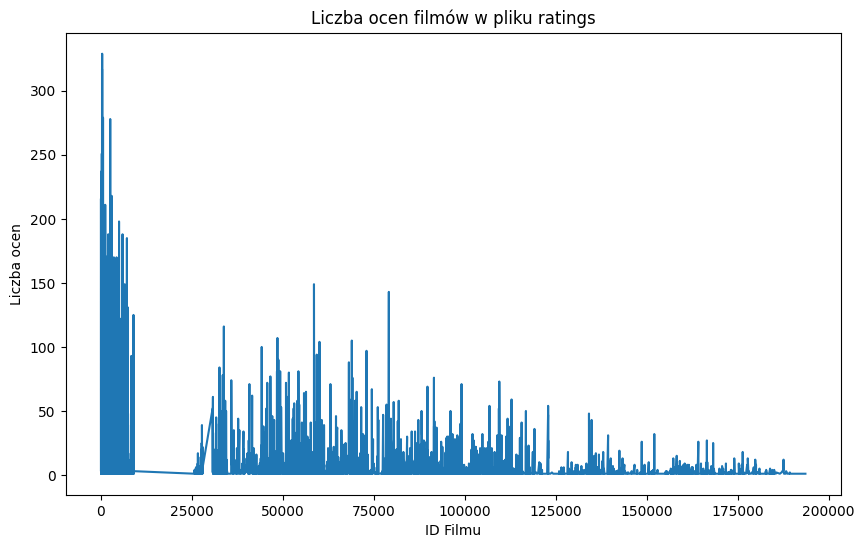

In [29]:
ilosc_ocen_filmow = ratings.groupby('movieId')['rating'].count()

plt.figure(figsize=(10, 6))
plt.plot(ilosc_ocen_filmow.index, ilosc_ocen_filmow.values)
plt.xlabel('ID Filmu')
plt.ylabel('Liczba ocen')
plt.title('Liczba ocen filmów w pliku ratings')
plt.show()

Widać dużą dysproporcje w ilościach ocen, które otrzymały filmy oraz ilościach opinii wystawionych przez konrektnych użytkowników. W związku z tym ograniczam zbiór danych

In [51]:
MIN_USER_RATINGS = 500
MIN_MOVIE_RATINGS = 50
nowi_uzytkownicy = ilosc_ocen_uzytkownika[ilosc_ocen_uzytkownika >= MIN_USER_RATINGS].index

nowe_filmy = ilosc_ocen_filmow[ilosc_ocen_filmow >= MIN_MOVIE_RATINGS].index

filtered_ratings = ratings[ratings['userId'].isin(nowi_uzytkownicy) & ratings['movieId'].isin(nowe_filmy)]

filtered_movies = movies[movies['movieId'].isin(nowe_filmy)]

# Filter ratings for frequent users and movies
filtered_ratings = ratings[ratings['userId'].isin(nowi_uzytkownicy) & ratings['movieId'].isin(nowe_filmy)]

# Merge ratings with movies to get movie titles and genres
ratings_merge = filtered_ratings.merge(movies[['movieId', 'title', 'genres']], how='left', on='movieId')


print("Number of users after filtering:", len(nowi_uzytkownicy))
print("Number of movies after filtering:", len(filtered_movies))
print("Number of ratings after filtering:", len(filtered_ratings))

Number of users after filtering: 44
Number of movies after filtering: 450
Number of ratings after filtering: 11102


In [52]:
reader = Reader(rating_scale=(1, 5))
data   = Dataset.load_from_df(ratings_merge[['userId','title','rating']], reader)

raw_ratings = data.raw_ratings
import random
random.shuffle(raw_ratings)

threshold   = int(len(raw_ratings)*0.8)

train_raw_ratings = raw_ratings[:threshold]
test_raw_ratings  = raw_ratings[threshold:]

data.raw_ratings = train_raw_ratings
trainset         = data.build_full_trainset()
testset          = data.construct_testset(test_raw_ratings)

Algorytm SVD

In [32]:


param_grid = {"n_factors": range(10,100,20),
              "n_epochs" : [5, 10, 20],
              "lr_all"   : [0.002, 0.005],
              "reg_all"  : [0.2, 0.5]}

gridsearchSVD = GridSearchCV(SVD, param_grid, measures=['mae', 'rmse'], cv=5, n_jobs=-1)

gridsearchSVD.fit(data)

print(f'MAE Best Parameters:  {gridsearchSVD.best_params["mae"]}')
print(f'MAE Best Score:       {gridsearchSVD.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchSVD.best_params["rmse"]}')
print(f'RMSE Best Score:      {gridsearchSVD.best_score["rmse"]}\n')

MAE Best Parameters:  {'n_factors': 70, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}
MAE Best Score:       0.627314397993248

RMSE Best Parameters: {'n_factors': 70, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}
RMSE Best Score:      0.8153099936075403



Kros walidacja dla estymatoru MAE i RMSE




In [46]:
svd_cv_results = cross_validate(gridsearchSVD.best_estimator['mae'], data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7933  0.8210  0.8041  0.8302  0.8280  0.8153  0.0143  
MAE (testset)     0.6149  0.6295  0.6206  0.6341  0.6354  0.6269  0.0079  
Fit time          0.61    0.65    0.31    0.31    0.31    0.44    0.16    
Test time         0.05    0.61    0.03    0.03    0.03    0.15    0.23    


In [47]:
svd_cv_results = cross_validate(gridsearchSVD.best_estimator['rmse'], data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7964  0.8101  0.8192  0.8173  0.8296  0.8145  0.0110  
MAE (testset)     0.6123  0.6239  0.6326  0.6309  0.6313  0.6262  0.0076  
Fit time          0.69    0.42    0.38    0.46    0.37    0.46    0.12    
Test time         0.05    0.06    0.05    0.05    0.05    0.05    0.00    


kNNwithMeans z wykorzystaniem metody hiperparametryzacji GridSearch do wyb

liczby sąsiadów od 3-10

In [36]:
param_grid = {
    'sim_options': {
        'name': ['msd', 'cosine'],
        'min_support': [3, 10],
        'user_based': [False, True]
    },
    'k': list(range(3, 11))
}

gridsearchKNNWithMeans = GridSearchCV(KNNWithMeans, param_grid, measures=['mae', 'rmse'], \
                                      cv=5, n_jobs=-1)

gridsearchKNNWithMeans.fit(data)

print(f'MAE Best Parameters:  {gridsearchKNNWithMeans.best_params["mae"]}')
print(f'MAE Best Score:       {gridsearchKNNWithMeans.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchKNNWithMeans.best_params["rmse"]}')


MAE Best Parameters:  {'sim_options': {'name': 'msd', 'min_support': 10, 'user_based': True}, 'k': 10}
MAE Best Score:       0.6290891347731027

RMSE Best Parameters: {'sim_options': {'name': 'cosine', 'min_support': 10, 'user_based': True}, 'k': 10}


In [37]:
sim_options = {'name':'cosine','min_support':3,'user_based':False}
final_model = KNNWithMeans(sim_options=sim_options)

pred = final_model.fit(trainset).test(testset)

print(f'\nUnbiased Testing Performance:')
print(f'MAE: {accuracy.mae(pred)}, RMSE: {accuracy.rmse(pred)}')

Computing the cosine similarity matrix...
Done computing similarity matrix.

Unbiased Testing Performance:
MAE:  0.6263
RMSE: 0.8108
MAE: 0.6262676841015767, RMSE: 0.8107637465605374


Kros walidacja dla estymatoru MAE i RMSE


In [48]:
knn_cv_results = cross_validate(gridsearchKNNWithMeans.best_estimator['mae'], data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8162  0.8172  0.8174  0.8189  0.8260  0.8191  0.0035  
MAE (testset)     0.6292  0.6278  0.6295  0.6271  0.6313  0.6290  0.0015  
Fit time          0.03    0.02    0.03    0.03    0.03    0.03    0.00    
Test time         0.20    0.21    0.40    0.21    0.21    0.25    0.08    


In [49]:
knn_cv_results = cross_validate(gridsearchKNNWithMeans.best_estimator['rmse'], data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8138  0.8313  0.8166  0.8293  0.8006  0.8183  0.0112  
MAE (testset)     0.6280  0.6406  0.6231  0.6396  0.6181  0.6299  0.0089  
Fit time          0.02    0.03    0.02    0.02    0.03    0.03    0.00    
Test time         0.22    0.20    0.21    0.20    0.22    0.21    0.01    


Oba modele wyszły bardzo podobnie

Czym różni się algorytm kNN with means od standardowego kNN?


Algorytm kNNWithMeans różni się od standardowego kNN tym, że oprócz znajdowania sąsiadów na podstawie podobieństwa, również uwzględnia średnią ocen tych sąsiadów. Dzięki temu, jeśli dany użytkownik ma tendencję do oceniania filmów wyżej lub niżej niż inni, algorytm ten może uwzględnić to w swoich rekomendacjach.

3. Podaj rekomendacje po obejrzeniu filmu: NeverEnding Story III oraz Pi

Zaczynam od znaleziena ID filmu. Następnie szukam użytkowników, którzy ocenili dany film i znajduje inne film, które oni ocenili wysoko, ale takie, których "ja" nie oceniłam. Wybieram filmy z wysoką średnią ocen.

In [44]:
neverending_story_3_id = movies[movies['title'].str.contains('NeverEnding Story III', case=False)]['movieId'].values
if len(neverending_story_3_id) > 0:
    neverending_story_3_id = neverending_story_3_id[0]

    uzytkownicy_ns3 = ratings[ratings['movieId'] == neverending_story_3_id]['userId'].unique()

    wysoko_ocenione_ns3 = ratings[(ratings['userId'].isin(uzytkownicy_ns3)) & (ratings['movieId'] != neverending_story_3_id)]\
                                .groupby('movieId')['rating'].mean()\
                                .sort_values(ascending=False)\
                                .reset_index()

    rekomendowane_ns3 = movies[movies['movieId'].isin(wysoko_ocenione_ns3['movieId'][:10])]\
                              [['movieId', 'title', 'genres']]

    print("Rekomendowane filmy po obejrzeniu 'NeverEnding Story III':")
    for i, film in rekomendowane_ns3.iterrows():
        print(f"{i+1}. {film['title']} ({film['genres']})")
else:
    print("Nie można znaleźć ID dla filmu 'NeverEnding Story III'.")



Rekomendowane filmy po obejrzeniu 'NeverEnding Story III':
695. Casablanca (1942) (Drama|Romance)
712. Notorious (1946) (Film-Noir|Romance|Thriller)
778. 20,000 Leagues Under the Sea (1954) (Adventure|Drama|Sci-Fi)
800. Beautiful Thing (1996) (Drama|Romance)
802. Ghost and the Darkness, The (1996) (Action|Adventure)
810. William Shakespeare's Romeo + Juliet (1996) (Drama|Romance)
818. Sleeper (1973) (Comedy|Sci-Fi)
821. Monty Python's Life of Brian (1979) (Comedy)
827. Dial M for Murder (1954) (Crime|Mystery|Thriller)
983. High Noon (1952) (Drama|Western)


In [45]:

pi_id = movies[movies['title'].str.contains('Pi', case=False)]['movieId'].values
if len(pi_id) > 0:
    pi_id = pi_id[0]

    uzytkownicy_pi = ratings[ratings['movieId'] == pi_id]['userId'].unique()

    wysoko_ocenione_pi = ratings[(ratings['userId'].isin(uzytkownicy_pi)) & (ratings['movieId'] != pi_id)]\
                                .groupby('movieId')['rating'].mean()\
                                .sort_values(ascending=False)\
                                .reset_index()

    rekomendowane_pi = movies[movies['movieId'].isin(wysoko_ocenione_pi['movieId'][:10])]\
                              [['movieId', 'title', 'genres']]

    print("\nRekomendowane filmy po obejrzeniu 'Pi':")
    for i, film in rekomendowane_pi.iterrows():
        print(f"{i+1}. {film['title']} ({film['genres']})")
else:
    print("Nie można znaleźć ID dla filmu 'Pi'.")


Rekomendowane filmy po obejrzeniu 'Pi':
252. Once Were Warriors (1994) (Crime|Drama)
960. M (1931) (Crime|Film-Noir|Thriller)
1648. Knock Off (1998) (Action)
1754. Nights of Cabiria (Notti di Cabiria, Le) (1957) (Drama)
2736. Benji the Hunted (1987) (Adventure|Children)
2883. Affair of Love, An (Liaison pornographique, Une) (1999) (Drama|Romance)
4010. Rules of Attraction, The (2002) (Comedy|Drama|Romance|Thriller)
4047. Gallipoli (1981) (Drama|War)
5083. Brigadoon (1954) (Fantasy|Musical|Romance)
5087. Spring, Summer, Fall, Winter... and Spring (Bom yeoreum gaeul gyeoul geurigo bom) (2003) (Drama)
